# Linear Regression

Simple 1D linear regression classifier

- Fits a single training example

In [42]:
x = 3
w = 1
y = 100

In [74]:
from collections import namedtuple

Model = namedtuple('Model', ['x', 'w', 'y_hat', 'y_true', 'perf', 'dperf', 'dy_hat', 'dw', 'dx'])

def lin_reg(x=1, w=1, y_true=1, learning_rate=0.01):
    """Run gradient descent on a single training example
    
    Yield successive states of the model
    
    """
    while True:
        # Forward Pass (prediction)
        y_hat = w * x

        # Compute loss (negate loss so we can think of maximizing output of the network)
        perf = -0.5 * (y_true-y_hat)**2

        # Backpropagate to find dw and dx
        dperf = 1
        dy_hat = (y_true-y_hat) * dperf
        dw, dx = x * dy_hat, w * dy_hat
        
        yield Model(x, w, y_hat, y_true, perf, dperf, dy_hat, dw, dx)
        
        # Gradient ascent
        w += learning_rate*dw

## Run the Model for a Certain Amount of Time Steps

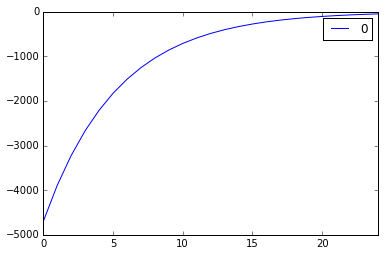

In [85]:
step = lin_reg(x=x, w=w, y_true=y)

pd.DataFrame(next(step).perf for _ in range(25)).plot()

## Performance Values and Derivatives for `(x=3,y=100)`

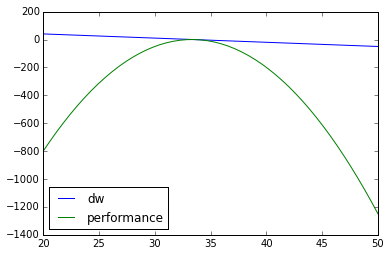

In [35]:
%matplotlib inline

import numpy as np
import pandas as pd

ws = np.linspace(20, 50)
pd.DataFrame({
        'performance': -0.5 * (100-ws*x)**2,
        'dw': 100-ws*x}, index=ws).plot()

## Finite Difference Gradient Check

In [46]:
def num_grads():
    """Generate a list of numerical gradients of each w in ws"""
    
    delta_w = 0.0001
    
    for w in ws:
        fwmdw = -0.5 * (100 - (w-delta_w)*x)**2
        fwpdw = -0.5 * (100 - (w+delta_w)*x)**2
        
        yield (fwpdw-fwmdw) / (2*delta_w)
        
num_grads = np.array(list(num_grads()))

In [53]:
def analytic_grads():
    """Return the analytic gradient for each w in ws"""
    
    for w in ws:
        yield next(lin_reg(x=x, w=w, y_true=100)).dw
        
analytic_grads = np.array(list(analytic_grads()))

## Gradient Comparisons

In [57]:
pd.DataFrame(num_grads - analytic_grads, index=ws).mean()

0   -1.414009e-09
dtype: float64